In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle
import numpy as np
import datetime as dt
from datetime import timedelta
import os
import glob

# Set up matplotlib style
plt.style.use('default')
plt.rcParams['figure.figsize'] = (20, 12)
plt.rcParams['font.size'] = 10


In [30]:
SYMBOL = "BTCUSDT"

# range percentage from price to upper and lower bound
# best for past year is 10.5
# best for past 3 years is 11.5
range_pct = 10.5

In [31]:
# Load data from CSV file
def find_csv():
    """Find CSV files in the current directory"""
    csv_files = glob.glob(f"{SYMBOL}_hourly_data_*.csv")
    return csv_files

def load_data(filename=None):
    """Load data from CSV file"""
    
    if filename is None:
        # Try to find CSV files automatically
        csv_files = find_csv()
        
        if not csv_files:
            print("No CSV files found in current directory.")
            print("Please ensure you have run the data fetching notebook first.")
            return None
        
        # Use the most recent file
        filename = max(csv_files, key=os.path.getctime)
        print(f"Found {len(csv_files)} CSV file(s)")
        print(f"Using most recent file: {filename}")
    
    try:
        # Load the CSV file
        df = pd.read_csv(filename)
        
        # Convert timestamp columns to datetime
        df['open_time'] = pd.to_datetime(df['open_time'])
        df['close_time'] = pd.to_datetime(df['close_time'])
        
        # Ensure data types are correct
        price_columns = ['open', 'high', 'low', 'close', 'volume', 'quote_asset_volume',
                         'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
        for col in price_columns:
            if col in df.columns:
                df[col] = df[col].astype(float)
        
        # Sort by open_time to ensure chronological order
        df = df.sort_values('open_time').reset_index(drop=True)
        
        print(f"✅ Successfully loaded {SYMBOL} data!")
        print(f"📊 Dataset: {len(df):,} hourly records")
        print(f"📅 Period: {df['open_time'].min().strftime('%Y-%m-%d %H:%M')} to {df['open_time'].max().strftime('%Y-%m-%d %H:%M')}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: File '{filename}' not found.")
        print("Please check the filename and try again.")
        return None
    except Exception as e:
        print(f"❌ Error loading data: {e}")
        return None

# Load the data
df = load_data()

if df is not None:
    print("\n🎯 Data loaded successfully! Ready for visualization.")


Found 1 CSV file(s)
Using most recent file: BTCUSDT_hourly_data_20240630_20250630.csv
✅ Successfully loaded BTCUSDT data!
📊 Dataset: 8,761 hourly records
📅 Period: 2024-06-29 17:00 to 2025-06-29 17:00

🎯 Data loaded successfully! Ready for visualization.


In [32]:
def simulate_rebalancing_with_periods(df, range_pct):
    """
    Simulate rebalancing and return detailed period information for visualization.
    
    Args:
        df: DataFrame with price data
        range_pct: Total range percentage (e.g., 0.21 for ±10.5% range = 21% total height)
    
    Returns:
        dict: Results including period details for visualization
    """
    if df is None or df.empty:
        return None
    
    prices = df['close'].values
    timestamps = df['open_time'].values
    
    rebalances = []
    periods = []  # Track detailed period information
    
    current_center = prices[0]  # Start with first price as center
    half_range = range_pct / 2
    
    rebalance_count = 0
    current_period_start = 0
    
    for i, price in enumerate(prices):
        # Calculate current range bounds
        lower_bound = current_center * (1 - half_range)
        upper_bound = current_center * (1 + half_range)
        
        # Check if price is outside range
        if price < lower_bound or price > upper_bound:
            # Record the period that just ended
            if i > current_period_start:
                periods.append({
                    'start_time': timestamps[current_period_start],
                    'end_time': timestamps[i-1],
                    'start_index': current_period_start,
                    'end_index': i-1,
                    'center_price': current_center,
                    'lower_bound': lower_bound,
                    'upper_bound': upper_bound,
                    'duration_hours': i - current_period_start,
                    'period_number': len(periods) + 1
                })
            
            # Rebalance: set new center to current price
            current_center = price
            rebalance_count += 1
            current_period_start = i
            
            rebalances.append({
                'timestamp': timestamps[i],
                'price': price,
                'rebalance_number': rebalance_count,
                'new_center': current_center
            })
    
    # Add final period
    if len(prices) > current_period_start:
        lower_bound = current_center * (1 - half_range)
        upper_bound = current_center * (1 + half_range)
        periods.append({
            'start_time': timestamps[current_period_start],
            'end_time': timestamps[-1],
            'start_index': current_period_start,
            'end_index': len(prices) - 1,
            'center_price': current_center,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'duration_hours': len(prices) - current_period_start,
            'period_number': len(periods) + 1
        })
    
    return {
        'range_pct': range_pct,
        'rebalance_count': rebalance_count,
        'rebalances': rebalances,
        'periods': periods,
        'total_hours': len(prices)
    }

# Run simulation for ±X% range
if df is not None:
    print("🚀 Running rebalancing simulation range...")
    half_range_pct = range_pct / 100
    range_pct = half_range_pct * 2
    simulation_result = simulate_rebalancing_with_periods(df, range_pct)
    
    if simulation_result:
        print(f"✅ Simulation complete!")
        print(f"📊 Total rebalances: {simulation_result['rebalance_count']}")
        print(f"📊 Total periods: {len(simulation_result['periods'])}")
        print(f"📊 Average period duration: {np.mean([p['duration_hours'] for p in simulation_result['periods']]):.1f} hours")


🚀 Running rebalancing simulation range...
✅ Simulation complete!
📊 Total rebalances: 18
📊 Total periods: 19
📊 Average period duration: 461.1 hours


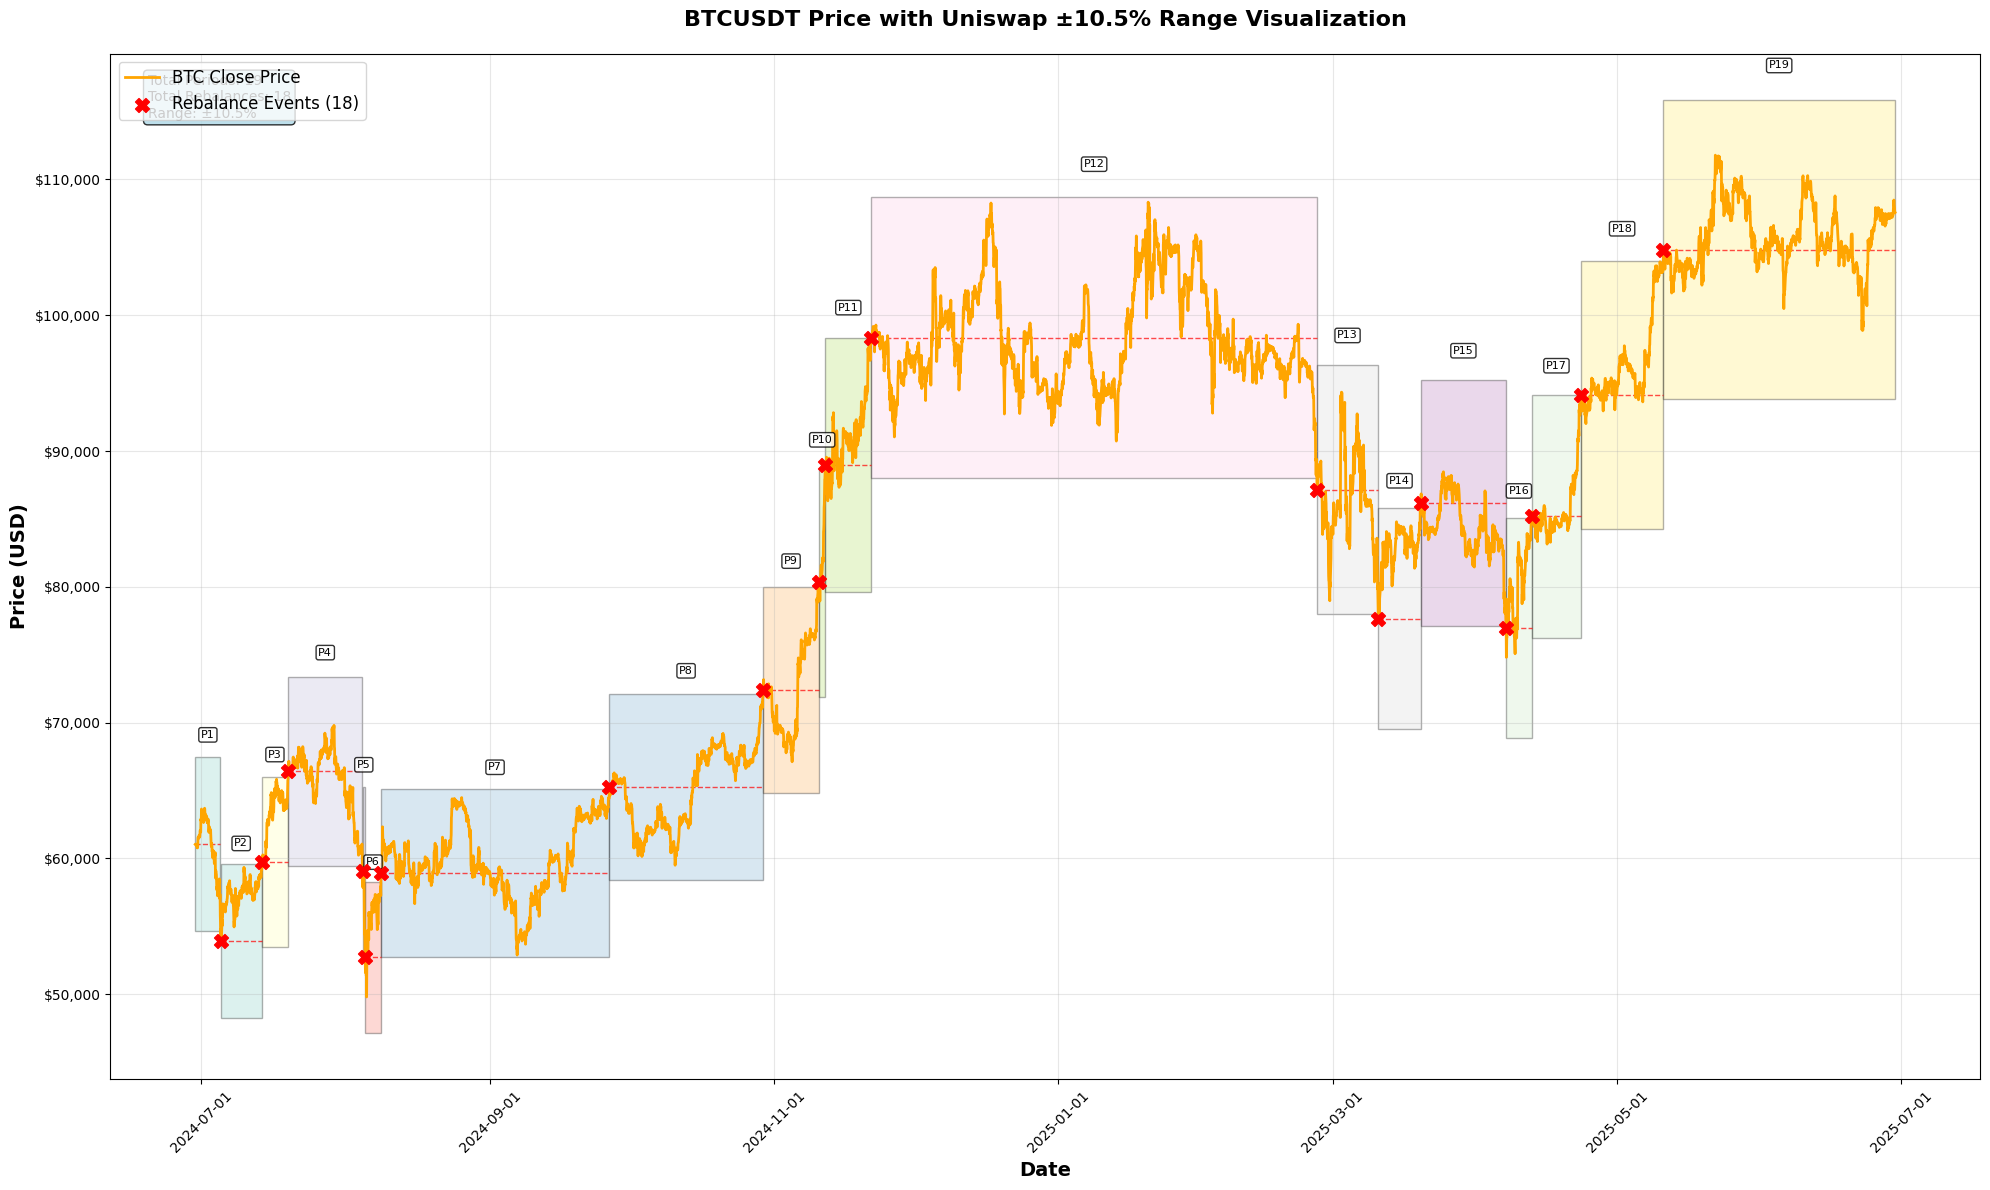

In [33]:
def create_range_visualization(df, simulation_result, time_window=None):
    """
    Create a comprehensive visualization of price with Uniswap range rectangles.
    
    Args:
        df: DataFrame with price data
        simulation_result: Result from simulate_rebalancing_with_periods
        time_window: Optional tuple (start_date, end_date) to zoom in on specific period
    """
    if df is None or simulation_result is None:
        print("❌ No data available for visualization")
        return
    
    # Filter data for time window if specified
    if time_window:
        start_date, end_date = time_window
        mask = (df['open_time'] >= start_date) & (df['open_time'] <= end_date)
        df_plot = df[mask].copy()
        # Filter periods that overlap with the time window
        periods_plot = [p for p in simulation_result['periods'] 
                       if p['end_time'] >= start_date and p['start_time'] <= end_date]
    else:
        df_plot = df.copy()
        periods_plot = simulation_result['periods']
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 12))
    
    # Plot price line
    ax.plot(df_plot['open_time'], df_plot['close'], 
            color='orange', linewidth=2, label='BTC Close Price', zorder=3)
    
    # Color palette for rectangles
    colors = plt.cm.Set3(np.linspace(0, 1, len(periods_plot)))
    
    # Add range rectangles for each period
    for i, period in enumerate(periods_plot):
        # Convert timestamps to matplotlib dates
        start_date_num = mdates.date2num(period['start_time'])
        end_date_num = mdates.date2num(period['end_time'])
        width = end_date_num - start_date_num
        
        # Rectangle dimensions
        height = period['upper_bound'] - period['lower_bound']
        bottom = period['lower_bound']
        
        # Create rectangle
        rect = Rectangle((start_date_num, bottom), width, height,
                        facecolor=colors[i % len(colors)], 
                        alpha=0.3, 
                        edgecolor='black', 
                        linewidth=1,
                        zorder=1)
        ax.add_patch(rect)
        
        # Add center line
        ax.hlines(y=period['center_price'], 
                 xmin=start_date_num, xmax=end_date_num,
                 colors='red', linestyles='--', alpha=0.7, linewidth=1, zorder=2)
        
        # Add period label (for first few periods or if zoomed in)
        if len(periods_plot) <= 20 or (time_window and len(periods_plot) <= 10):
            mid_date = start_date_num + width/2
            ax.text(mid_date, period['upper_bound'] + (period['upper_bound'] - period['lower_bound']) * 0.1, 
                   f'P{period["period_number"]}', 
                   ha='center', va='bottom', fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8),
                   zorder=4)
    
    # Mark rebalance points
    rebalance_times = [r['timestamp'] for r in simulation_result['rebalances']]
    rebalance_prices = [r['price'] for r in simulation_result['rebalances']]
    
    # Filter rebalances for time window
    if time_window:
        rebalance_mask = [(t >= time_window[0] and t <= time_window[1]) for t in rebalance_times]
        rebalance_times = [t for i, t in enumerate(rebalance_times) if rebalance_mask[i]]
        rebalance_prices = [p for i, p in enumerate(rebalance_prices) if rebalance_mask[i]]
    
    if rebalance_times:
        ax.scatter(rebalance_times, rebalance_prices, 
                  color='red', s=100, marker='X', 
                  label=f'Rebalance Events ({len(rebalance_times)})', zorder=5)
    
    # Formatting
    ax.set_xlabel('Date', fontsize=14, fontweight='bold')
    ax.set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
    
    title = f'{SYMBOL} Price with Uniswap ±{simulation_result["range_pct"]/2*100:.1f}% Range Visualization'
    if time_window:
        title += f'\n{time_window[0].strftime("%Y-%m-%d")} to {time_window[1].strftime("%Y-%m-%d")}'
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Format x-axis
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.xticks(rotation=45)
    
    # Format y-axis with proper currency formatting
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    # Grid and legend
    ax.grid(True, alpha=0.3, zorder=0)
    ax.legend(loc='upper left', fontsize=12)
    
    # Add info box
    info_text = f"Total Periods: {len(simulation_result['periods'])}\n"
    info_text += f"Total Rebalances: {simulation_result['rebalance_count']}\n"
    info_text += f"Range: ±{simulation_result['range_pct']/2*100:.1f}%"
    
    ax.text(0.02, 0.98, info_text, 
           transform=ax.transAxes, fontsize=10,
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Create the main visualization
if df is not None and simulation_result is not None:
    create_range_visualization(df, simulation_result)


🔍 Creating zoomed-in visualization for better detail...


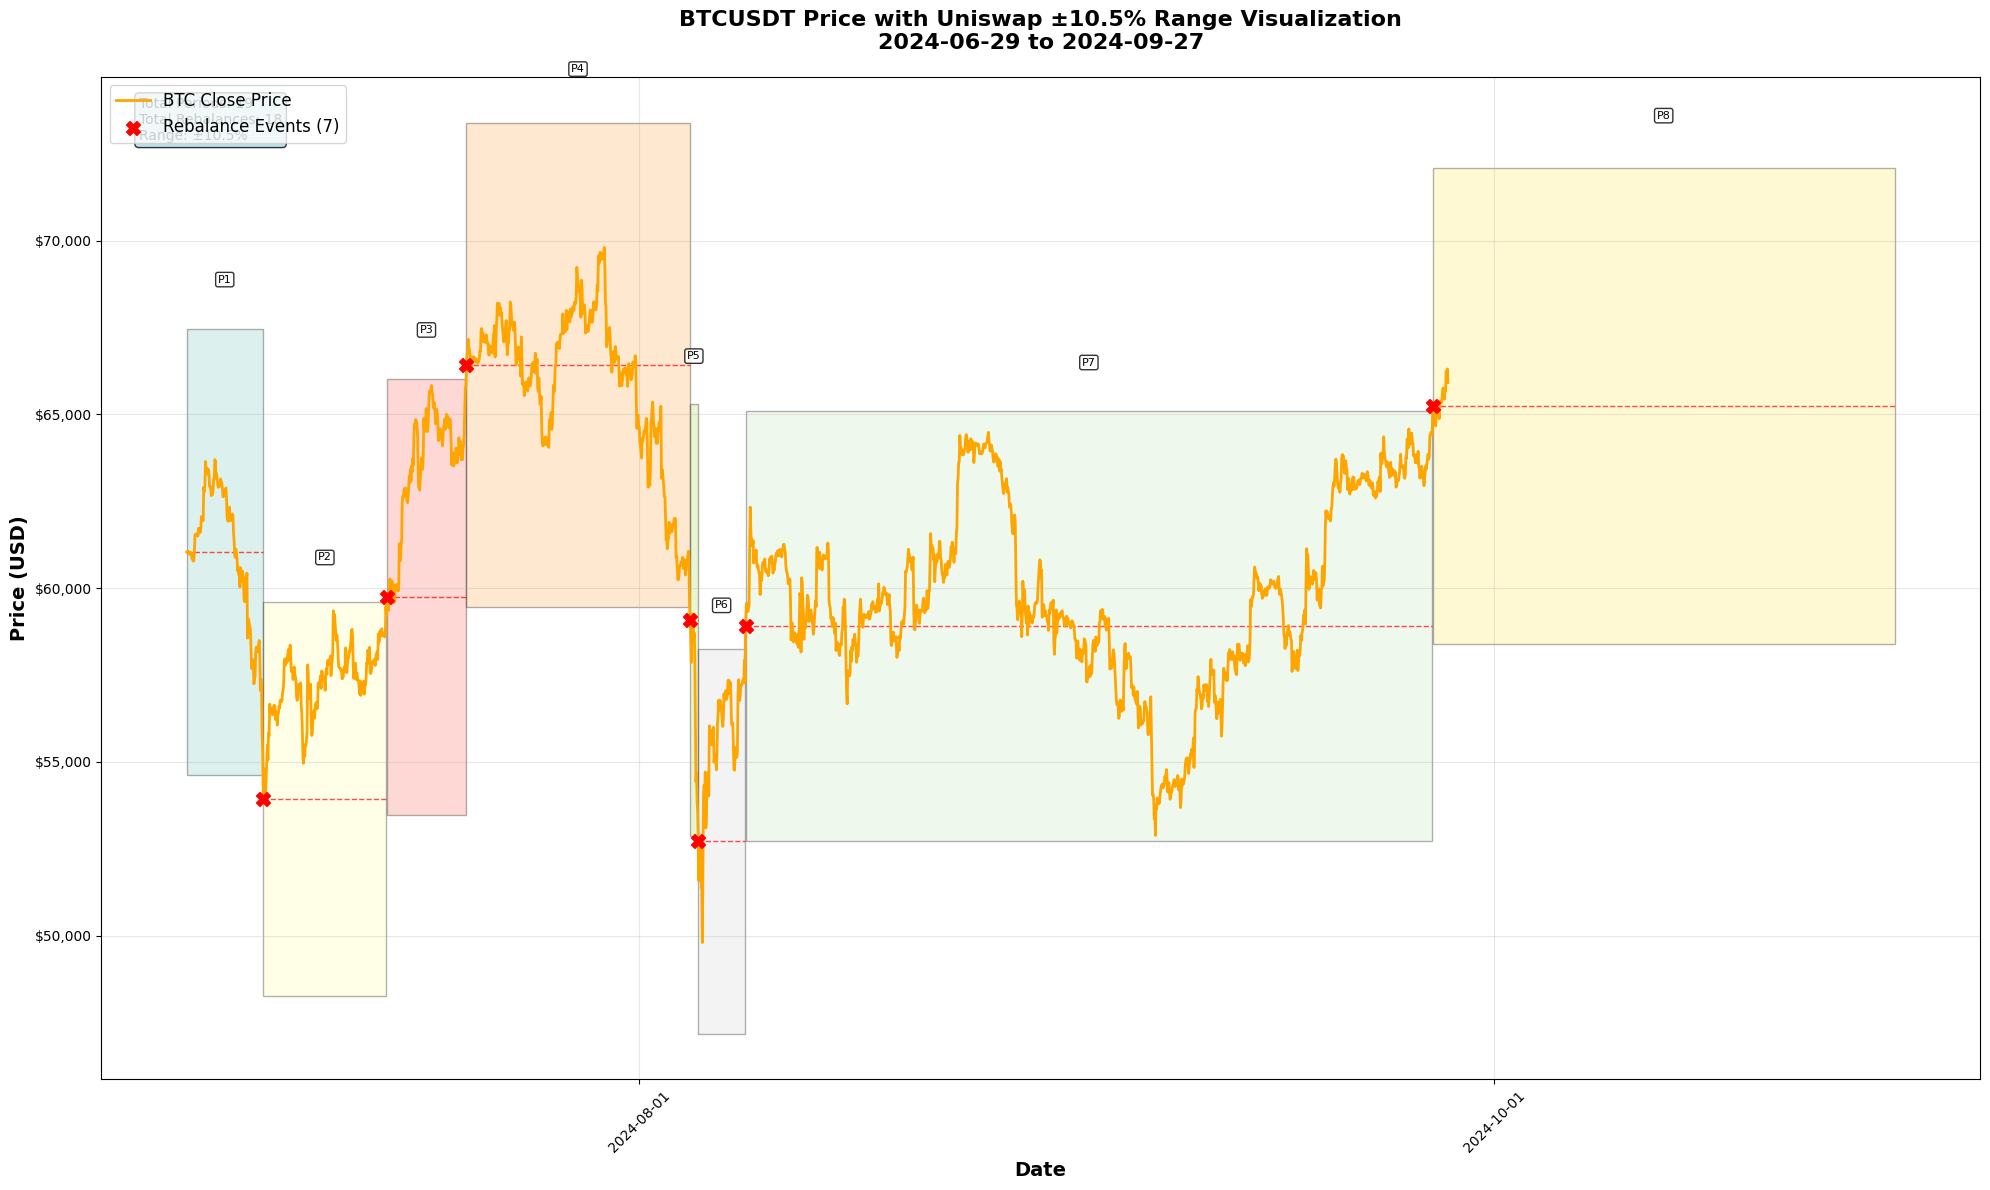

✅ Zoomed visualization complete!


In [34]:
# Create a zoomed-in view for better detail (e.g., first 3 months)
if df is not None and simulation_result is not None:
    print("🔍 Creating zoomed-in visualization for better detail...")
    
    # Define time window for zooming (first 3 months)
    start_date = df['open_time'].min()
    end_date = start_date + pd.Timedelta(days=90)  # 3 months
    
    create_range_visualization(df, simulation_result, time_window=(start_date, end_date))
    print("✅ Zoomed visualization complete!")


In [35]:
# Summary statistics and insights
if simulation_result is not None:
    print("📊 UNISWAP RANGE ANALYSIS SUMMARY")
    print("=" * 50)
    print(f"Range Width: ±{simulation_result['range_pct']/2*100:.1f}%")
    print(f"Total Simulation Period: {simulation_result['total_hours']} hours")
    print(f"Total Rebalances: {simulation_result['rebalance_count']}")
    print(f"Total Range Periods: {len(simulation_result['periods'])}")
    print("\n📈 PERIOD STATISTICS")
    print("-" * 30)
    
    durations = [p['duration_hours'] for p in simulation_result['periods']]
    print(f"Average Period Duration: {np.mean(durations):.1f} hours ({np.mean(durations)/24:.1f} days)")
    print(f"Median Period Duration: {np.median(durations):.1f} hours ({np.median(durations)/24:.1f} days)")
    print(f"Shortest Period: {min(durations)} hours ({min(durations)/24:.1f} days)")
    print(f"Longest Period: {max(durations)} hours ({max(durations)/24:.1f} days)")
    
    print("\n🔄 REBALANCING FREQUENCY")
    print("-" * 30)
    months = simulation_result['total_hours'] / (24 * 30)
    print(f"Rebalances per Month: {simulation_result['rebalance_count'] / months:.1f}")
    print(f"Days between Rebalances: {(simulation_result['total_hours'] / 24) / (simulation_result['rebalance_count'] + 1):.1f}")
    
    # Show first few periods for detail
    print("\n🎯 FIRST 5 PERIODS DETAIL")
    print("-" * 40)
    for i, period in enumerate(simulation_result['periods'][:5]):
        # Convert numpy datetime64 to pandas datetime for strftime
        start_time = pd.to_datetime(period['start_time'])
        end_time = pd.to_datetime(period['end_time'])
        print(f"Period {period['period_number']}: {start_time.strftime('%Y-%m-%d %H:%M')} to {end_time.strftime('%Y-%m-%d %H:%M')}")
        print(f"  └ Duration: {period['duration_hours']} hours ({period['duration_hours']/24:.1f} days)")
        print(f"  └ Center: ${period['center_price']:,.0f} | Range: ${period['lower_bound']:,.0f} - ${period['upper_bound']:,.0f}")
        print()


📊 UNISWAP RANGE ANALYSIS SUMMARY
Range Width: ±10.5%
Total Simulation Period: 8761 hours
Total Rebalances: 18
Total Range Periods: 19

📈 PERIOD STATISTICS
------------------------------
Average Period Duration: 461.1 hours (19.2 days)
Median Period Duration: 253.0 hours (10.5 days)
Shortest Period: 14 hours (0.6 days)
Longest Period: 2296 hours (95.7 days)

🔄 REBALANCING FREQUENCY
------------------------------
Rebalances per Month: 1.5
Days between Rebalances: 19.2

🎯 FIRST 5 PERIODS DETAIL
----------------------------------------
Period 1: 2024-06-29 17:00 to 2024-07-05 03:00
  └ Duration: 131 hours (5.5 days)
  └ Center: $61,041 | Range: $54,631 - $67,450

Period 2: 2024-07-05 04:00 to 2024-07-13 23:00
  └ Duration: 212 hours (8.8 days)
  └ Center: $53,941 | Range: $48,277 - $59,605

Period 3: 2024-07-14 00:00 to 2024-07-19 15:00
  └ Duration: 136 hours (5.7 days)
  └ Center: $59,754 | Range: $53,480 - $66,028

Period 4: 2024-07-19 16:00 to 2024-08-04 14:00
  └ Duration: 383 hours (